# Import Packages

In [512]:
#Import required packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [513]:
import os
import glob
os.listdir("test_images/")

['Challenge_image1.jpg',
 'Challenge_image2.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

# Read an image

In [514]:
def displayImages(images, cmap=None):
    columns = 2
    rows = (len(images)+1)/columns
    plt.figure(figsize=(10, 12))
    
    for i, image in enumerate(images):
        plt.subplot(rows, columns, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        
        plt.xticks([])
        plt.yticks([])
           
    plt.tight_layout()
    plt.show()

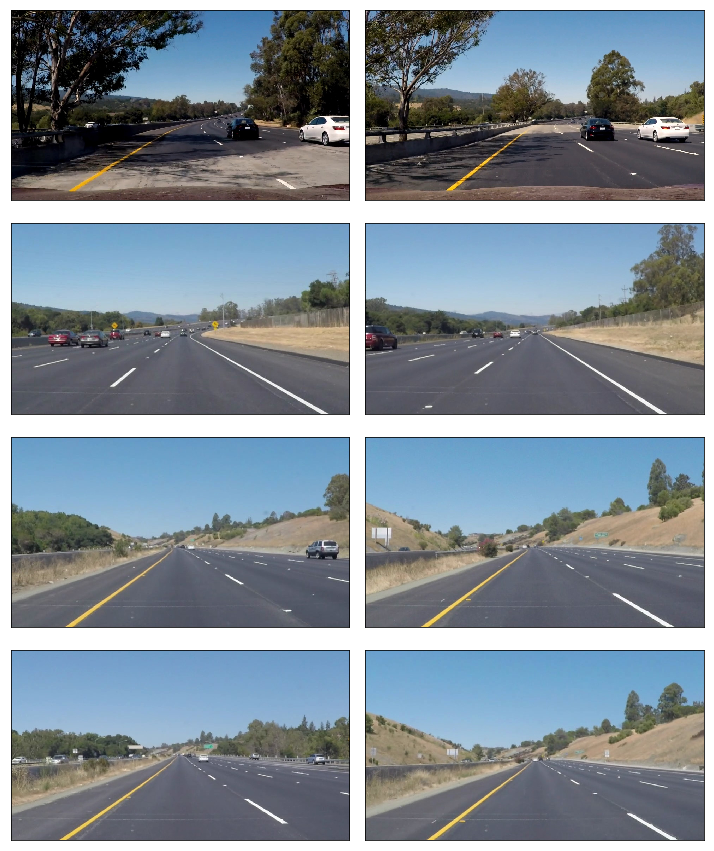

In [515]:
testImages = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
displayImages(testImages)

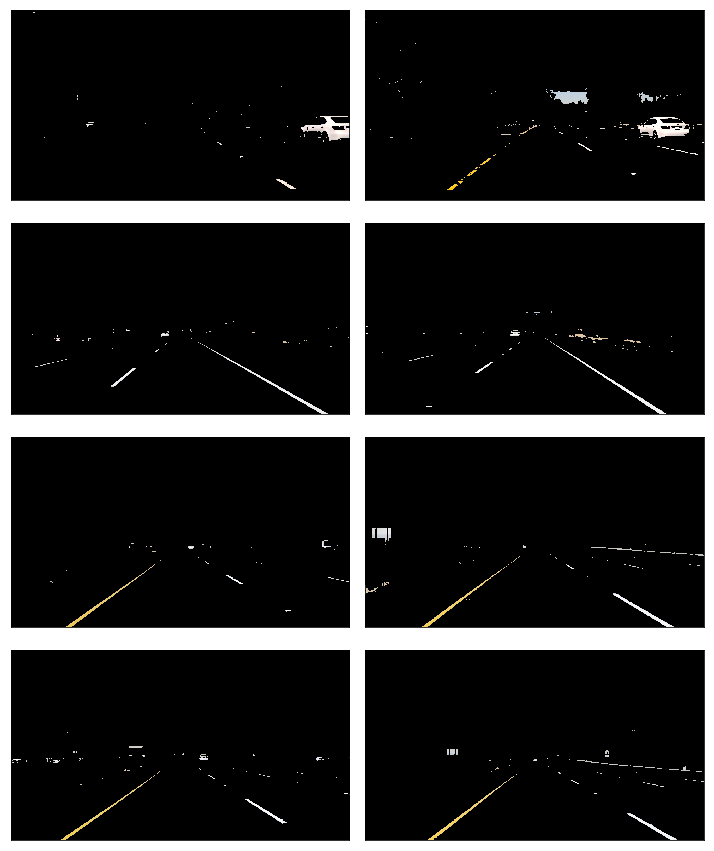

In [516]:
def colorSelectWhiteYellow(image): 
    # white color mask
    white_lower = np.uint8([210, 210, 210])
    white_upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, white_lower, white_upper)
    
    # yellow color mask
    yellow_lower = np.uint8([190, 190,   0])
    yellow_upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, yellow_lower, yellow_upper)
    
    # combine the mask
    mask_combined = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask_combined)
    return masked_image

displayImages(list(map(color_select_white_yellow, testImages)))

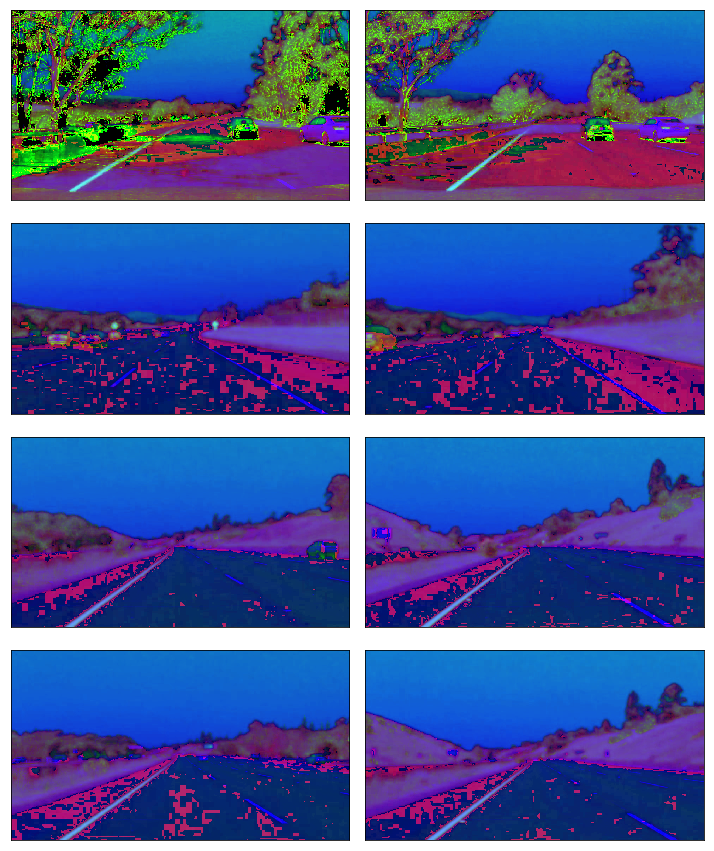

In [517]:
def convertToHSV(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

displayImages(list(map(convertToHSV, testImages)))

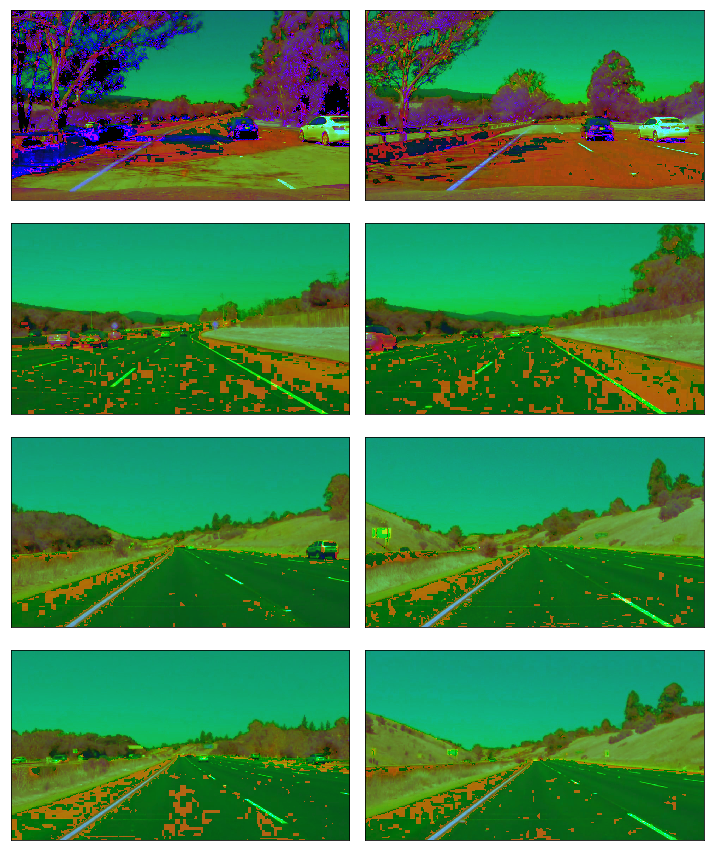

In [518]:
def convertToHSL(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

displayImages(list(map(convertToHSL, testImages)))

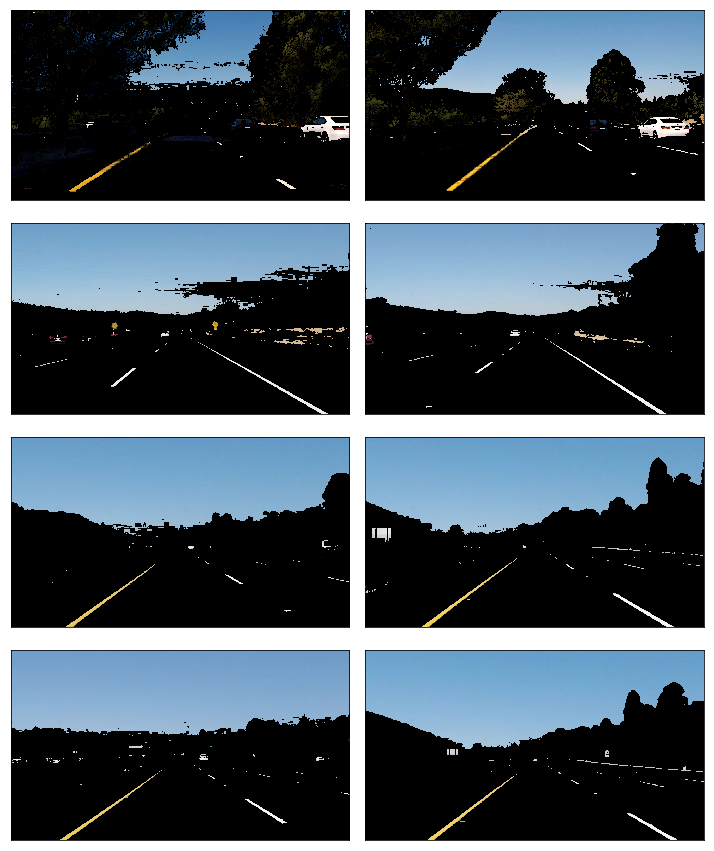

In [519]:
def filterWhiteYellow(image):
    imageHSL = convertToHSL(image)
    # white color mask
    white_lower = np.uint8([  0, 190,   0])
    white_upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(imageHSL, white_lower, white_upper)
    
    # yellow color mask
    yellow_lower = np.uint8([ 0,   0, 100])
    yellow_upper = np.uint8([ 150, 255, 255])
    yellow_mask = cv2.inRange(imageHSL, yellow_lower, yellow_upper)
    
    # combine the mask
    mask_combined = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask_combined)
    return masked_image

filterImages = list(map(filterWhiteYellow, testImages))
displayImages(filterImages)

# Make copy of image and convert to grayscale image

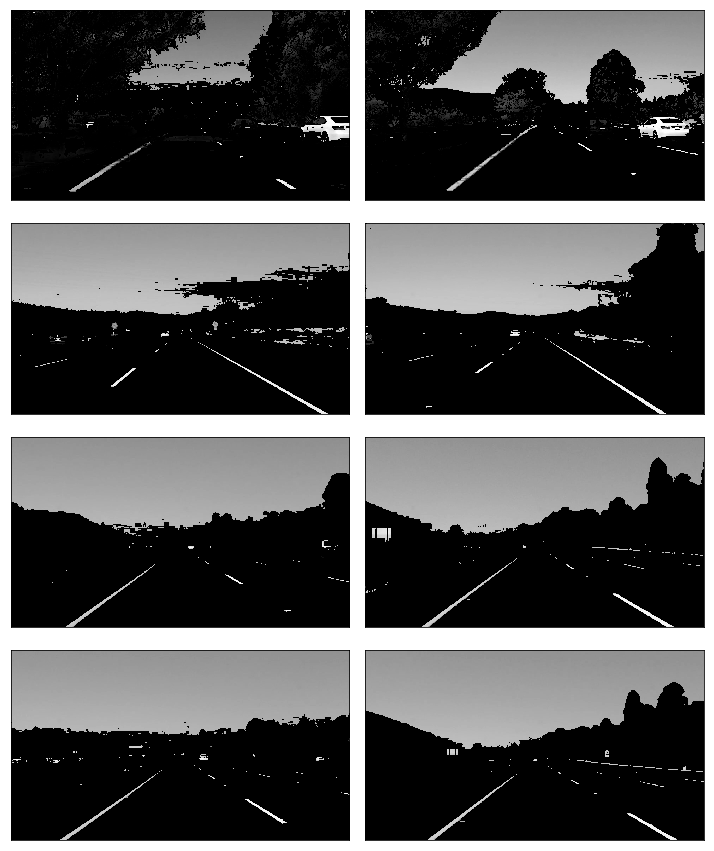

In [520]:
def convertToGrayscale(image):
    #Make a copy of the original image
    image_initial = np.copy(image)
        
    #Convert image to grayscale
    return cv2.cvtColor(image_initial, cv2.COLOR_RGB2GRAY) 
    
grayImages = list(map(convertToGrayscale, filterImages))
displayImages(grayImages)  

# Gaussian Blur

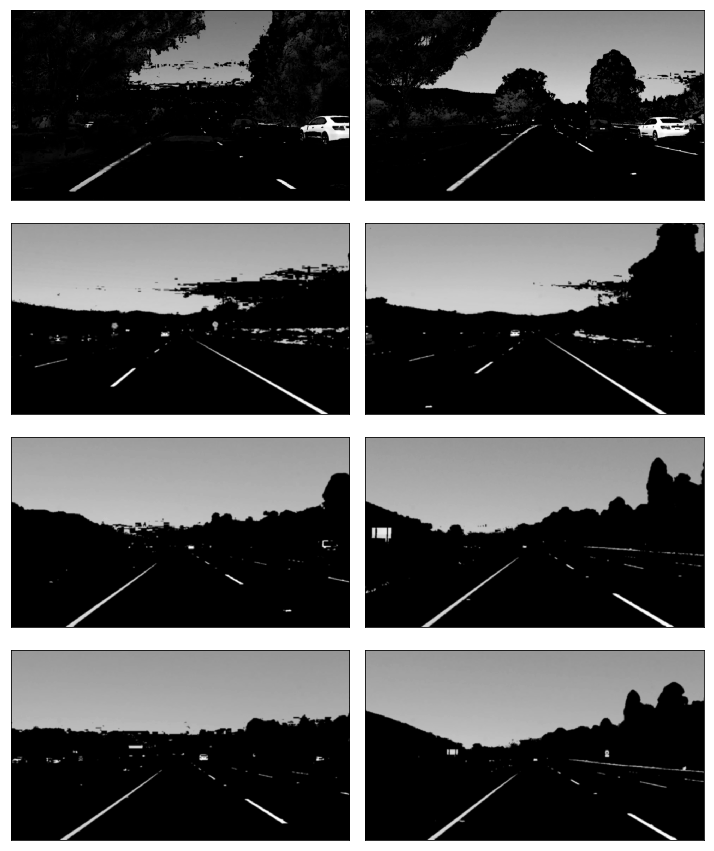

In [521]:
kernel_size = 7

def gaussianBlur(image, kernel_size):
    #Apply a Gaussian Noise kernel
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blurImages = list(map(lambda image:gaussianBlur(image, kernel_size), grayImages))
displayImages(blurImages)


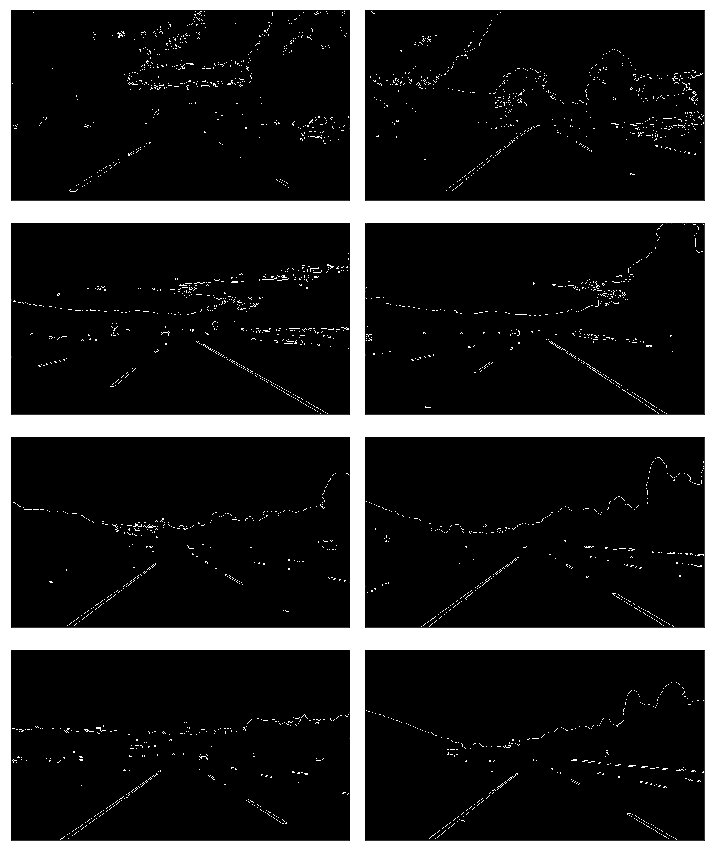

In [522]:
low_threshold = 50
high_threshold = 150

def canny(image, low_threshold, high_threshold):
    #Apply Canny transform
    return cv2.Canny(image, low_threshold, high_threshold)

edgeImages = list(map(lambda image:canny(image, low_threshold, high_threshold), blurImages))
displayImages(edgeImages)

# Region of interest

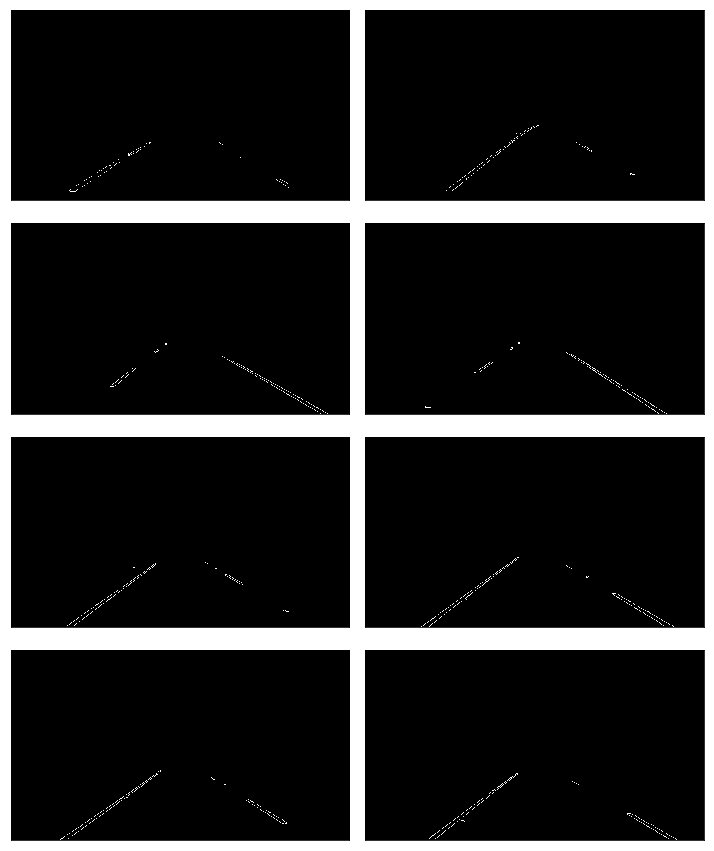

In [523]:
def regionOfInterest(image):
    # first, define the polygon by vertices
    ysize, xsize = image.shape[:2]
    bottomLeft  = [0, ysize]
    topLeft     = [xsize*0.45, ysize*0.6]
    topRight    = [xsize*0.5, ysize*0.6] 
    bottomRight = [xsize, ysize]
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottomLeft, topLeft, topRight, bottomRight]], dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# images showing the region of interest only
imagesROI = list(map(regionOfInterest, edgeImages))
displayImages(imagesROI)

# Hough Transform

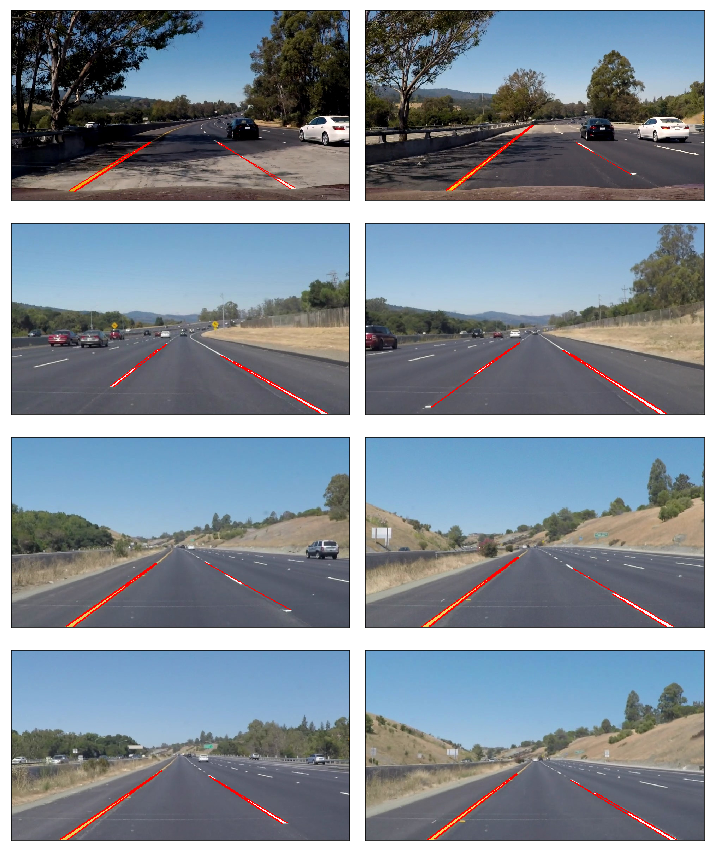

In [524]:
# Define the Hough transform parameters
rho = 1
theta = np.pi/180
threshold = 50
min_line_len = 50
max_line_gap = 200  
lineImages = []
    
def houghLines(image):
    return cv2.HoughLinesP(image, rho, theta, threshold, minLineLength=min_line_len, maxLineGap=max_line_gap)
    
houghLinesOutput = list(map(houghLines, imagesROI)) 

def drawLinesImages(image, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)   
    return image      

for image, lines in zip(testImages, houghLinesOutput):
    lineImages.append(drawLinesImages(image, lines))
    
displayImages(lineImages)

In [525]:
def average(lines):
    left_lines    = [] # (slope, intercept)
    right_lines   = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)

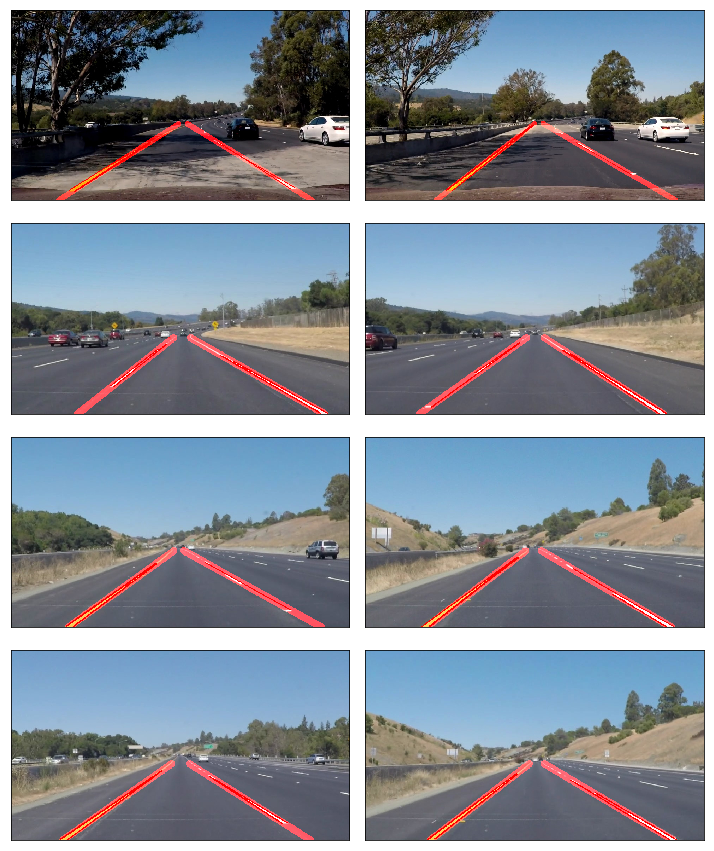

In [526]:
def findEndPoints(y1, y2, line):
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

def findLaneLines(image, lines):
    left_lane, right_lane = average(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = findEndPoints(y1, y2, left_lane)
    right_line = findEndPoints(y1, y2, right_lane)
    
    return left_line, right_line

    
def drawLinesVideo(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)
             
    
lane_images = []
for image, lines in zip(testImages, houghLinesOutput):
    lane_images.append(drawLinesVideo(image, findLaneLines(image, lines)))

    
show_images(lane_images)

# Main function

In [527]:
from collections import deque

QUEUE_LENGTH=50

class LaneDetector:
    def __init__(self):
        self.left_lines  = deque(maxlen=QUEUE_LENGTH)
        self.right_lines = deque(maxlen=QUEUE_LENGTH)

    def process(self, image):
        filteredImage = filterWhiteYellow(image)
        grayImage = convertToGrayscale(image)
        gaussianBlurImage = gaussianBlur(grayImage, kernel_size)
        cannyImage = canny(gaussianBlurImage, low_threshold, high_threshold)
        regionOfInterestImage = regionOfInterest(cannyImage)
        houghLinesImage = houghLines(regionOfInterestImage)
        left_line, right_line = findLaneLines(image, lines)

        def mean_line(line, lines):
            if line is not None:
                lines.append(line)

            if len(lines)>0:
                line = np.mean(lines, axis=0, dtype=np.int32)
                line = tuple(map(tuple, line)) # make sure it's tuples not numpy array for cv2.line to work
            return line

        left_line  = mean_line(left_line,  self.left_lines)
        right_line = mean_line(right_line, self.right_lines)

        return drawLinesVideo(image, (left_line, right_line))

In [ ]:
testinggggggggggggggggggg

def average_and_drawLaneLines(image, lines, yLimit, color=[[255, 0, 0], [0, 0, 255]], thickness = 15):
    
    leftLane = np.empty([1,3])  #slope,intercept,length
    rightLane = np.empty([1,3]) #slope,intercept,length
    
    ## calculate slopes for each line to identify the positive and negative lines
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0 and length > 10:
                leftLane = np.append(leftLane,np.array([[slope, intercept, length]]),axis = 0)
            elif slope > 0 and length > 10:
                rightLane = np.append(rightLane,np.array([[slope, intercept, length]]),axis = 0)
            else:
                pass
    
    ## just keep the observations with slopes with 1.5 std dev
    #leftLane = leftLane[to_keep_index(leftLane[:,0])]
    #rightLane = rightLane[to_keep_index(rightLane[:,0])]
    
    ## weighted average of the slopes and intercepts based on the length of the line segment
    leftLine = np.dot(leftLane[1:,2],leftLane[1:,:2])/np.sum(leftLane[1:,2]) if len(leftLane[1:,2]) > 0 else None
    rightLine = np.dot(rightLane[1:,2],rightLane[1:,:2])/np.sum(rightLane[1:,2]) if len(rightLane[1:,2]) > 0 else None
    
    leftIntercept = leftLine[1]
    leftSlope = leftLine[0]
    rightIntercept = rightLine[1]
    rightSlope = rightLine[0]
    
    left_y1 = image.shape[0]
    left_x1 = int((left_y1 - leftIntercept) / leftSlope)

    left_y2 = yLimit
    left_x2 = int((left_y2 - leftIntercept) / leftSlope)

    right_y1 = image.shape[0]
    right_x1 = int((right_y1 - rightIntercept) / rightSlope)

    right_y2 = yLimit
    right_x2 = int((right_y2 - rightIntercept) / rightSlope)
    
    cv2.line(image, (left_x1, left_y1), (left_x2, left_y2), color[0], thickness)
    cv2.line(image, (right_x1, right_y1), (right_x2, right_y2), color[1], thickness)

##### Video

In [528]:
def process_video(video_input, video_output):
    detector = LaneDetector()

    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process)
    processed.write_videofile(os.path.join('output_videos', video_output), audio=False)

In [530]:
%time process_video('solidWhiteRight.mp4', 'white.mp4')

OSError: [WinError 6] The handle is invalid